In [2]:
using Distributions, PyPlot

In [61]:
srand(8675309)
N = 11
s = .5 #Service level  #b = s/(1-s)
p0 = 1
K = 1000

alpha_grid = linspace(0, .99, 100)

#Gen Pks uniformly over interval for now
ps = rand(K);

In [58]:
#xk = 1 iff p(alpha) > 1-s

#prob xk = 1
function prob_k(alpha, p, N, p0, useNorm)
    dist = useNorm ? Normal(N*p, N * p * (1-p)) : Binomial(N, p)
    1-cdf(dist, N * (1 - s - alpha * p0) / (1-alpha))
end    
    
#Expected Obj at alpha
function obj_k(alpha, p, N, p0, useNorm)
    val = (1 - s - p) * prob_k(alpha, p, N, p0, useNorm) + p * s
    val/(1-s)
end

function var_obj_k(alpha, p, N, p0, useNorm)
    q = prob_k(alpha, p, N, p0, useNorm)
    (1-s-p)^2/(1-s)^2 * q * (1-q)
end

obj(alpha, ps, N, p0, useNorm) = mean(map(p-> obj_k(alpha, p, N, p0, useNorm), ps))
var(alpha, ps, N, p0, useNorm) = mean(map(p->var_obj_k(alpha, p, N, p0, useNorm), ps))/K

var (generic function with 1 method)

### First study dependence of $q(\alpha)$

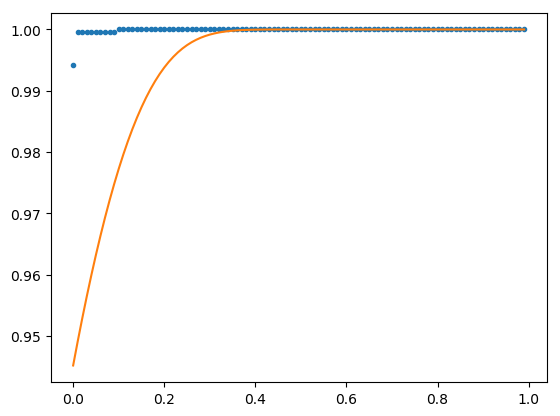

1-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x1349d8050>

In [59]:
p0 = 1
p = .5
qs = map(a->prob_k(a, p, N, p0, false), alpha_grid)
qs_norm = map(a->prob_k(a, p, N, p0, true), alpha_grid)

plot(alpha_grid, qs, ".")
plot(alpha_grid, qs_norm, "-")

### Actual Cost computations

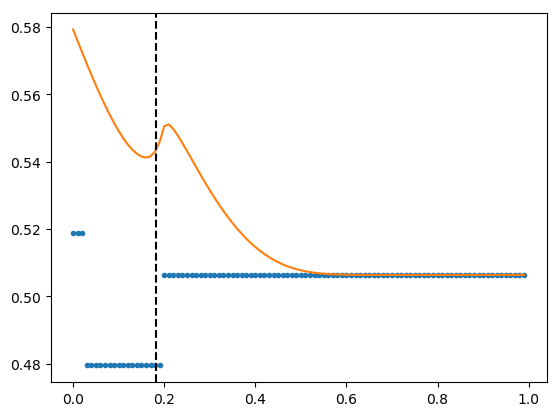

(0.03, 0.4794418666092479, 0.07577174630615369)

In [60]:
p0 = .5
out = map(a->obj(a, ps, N, p0, false), alpha_grid)
out_norm = map(a->obj(a, ps, N, p0, true), alpha_grid)

plot(alpha_grid, out, ".")
plot(alpha_grid, out_norm, "-")
axvline(2/N, color="k", linestyle="dashed")

alphaOR = alpha_grid[indmin(out)]
alphaOR, minimum(out), 1-minimum(out)/out[1]

### Some Notes
 - Oracle can offer no benefit for all of p0 = 0, .5, 1
 - Normal approximation can be quite bad... suggests there is a benefit when there isn't.

### Original and shrunken cost-curves

In [ ]:
#Plots the SAA cost curve across p_k and the shrunken cost curve across p_k.  Notice, Benefits when p_k > 1-q.

saa_objs = map(p-> obj_k(0, p, p0), ps)
or_objs = map(p->obj_k(alphaOR, p, p0), ps)
#full_objs = map(p->obj_k(.99, p, p0), ps)

plot(ps, saa_objs, ".")
plot(ps, or_objs, ".r")
#plot(ps, full_objs, "--k")
axhline(out[1])
axhline(minimum(out), color="r")
axvline(1-q, linestyle="dotted", color="k")

In [ ]:
##Evaluate the "deriv" at two points equally spaced from 1-q

delta = .01
low = 1-q - delta
high= 1-q + delta

function prob_deriv(p, p0, alpha)
    prob_portion(alpha, p, p0) - prob_portion(0, p, p0)
end
delta_grid = linspace(0, 1-q, 30)
low = map(d->prob_deriv(1-q-d, p0, alphaOR), delta_grid)
high= map(d->prob_deriv(1-q+d, p0, alphaOR), delta_grid)

plot(delta_grid, low, "--k")
plot(delta_grid, high, "--r")



### Plots the losses for $p_k < 1-q$ vs. the benefits for $p_k > 1-q$

In [ ]:
saa_objs = map(p-> obj_k(0, p, p0), ps)
or_objs = map(p->obj_k(alphaOR, p, p0), ps)

diff = or_objs - saa_objs

filt = ps .> 1-q
plot(ps[filt] - (1 -q), -diff[filt], ".")
plot(1-q -ps[.!filt], diff[.!filt], ".r")